In [8]:
import IProgress
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import time
import os
import copy


In [7]:
device = torch.device('mps')
device

device(type='mps')

In [14]:
from random import shuffle


data_transforms = {
    "Train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456,0.406], [0.229,0.224, 0.225])
    ]),
    "Val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456,0.406], [0.229,0.224, 0.225])
    ])
}

data_dir = 'data'

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['Train', 'Val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle=True, num_workers=4)
                for x in ['Train','Val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Val']}

class_names = image_datasets['Train'].classes

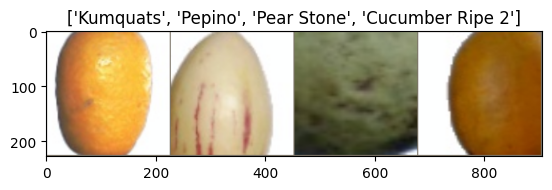

In [13]:
# define a function to visualize some images

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456,0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['Train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

In [ ]:
# define a generic function to train models

def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) 
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch} / {num_epochs - 2}")
        print("-" * 10)

        # each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train() # set the model to training mode
            
            else:
                model.eval() # set the model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward track history if in Train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward and optimize only if in training
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'Val':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]